In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import math

In [2]:
image = cv2.imread('/content/03-Leffy-bina-ya-donya.png', cv2.IMREAD_GRAYSCALE)


In [3]:
# gray_image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)

# Apply adaptive thresholding
_, thresh_image = cv2.threshold(image, 90, 255, cv2.THRESH_BINARY)


In [4]:
def get_hough(img):
    # Apply Canny edge detection
    edges = cv2.Canny(img, 50, 150)

    # Apply Hough transform
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=30, minLineLength=50, maxLineGap=190)

    # Create a black mask
    mask = np.zeros_like(img)

    # Draw Hough lines on the mask
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask, (x1, y1), (x2, y2), (255, 255, 255), 2)

    return mask

In [5]:
def get_largest_square_contour(image):
    # Find contours in the image
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables to keep track of the largest square contour
    max_area = 0
    largest_square_contour = None

    # Iterate through each contour
    for cnt in contours:
        # Calculate the bounding rectangle dimensions
        x, y, w, h = cv2.boundingRect(cnt)


        # Calculate the aspect ratio
        ratio = float(w) / h

        # Check if the aspect ratio is close to 1 (approximate square)
        if ratio >= 0.9 and ratio <= 1.1:
            # Check if the width and height are similar (closer to a square)
            if abs(w - h) <= 10:  # Adjust the threshold as needed
                # Calculate the area of the contour
                area = cv2.contourArea(cnt)

                # Update the largest square contour if the current contour has a larger area
                if area > max_area:
                    max_area = area
                    largest_square_contour = cnt

    return largest_square_contour


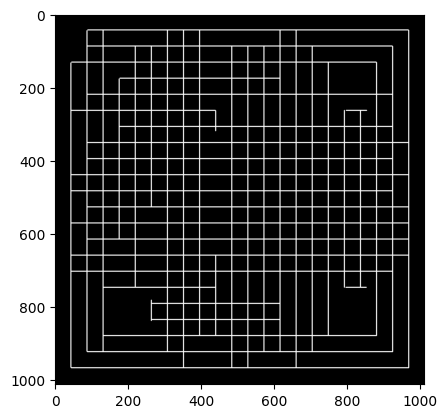

In [6]:
image_with_hough = get_hough(thresh_image)
plt.imshow(image_with_hough, cmap='gray')

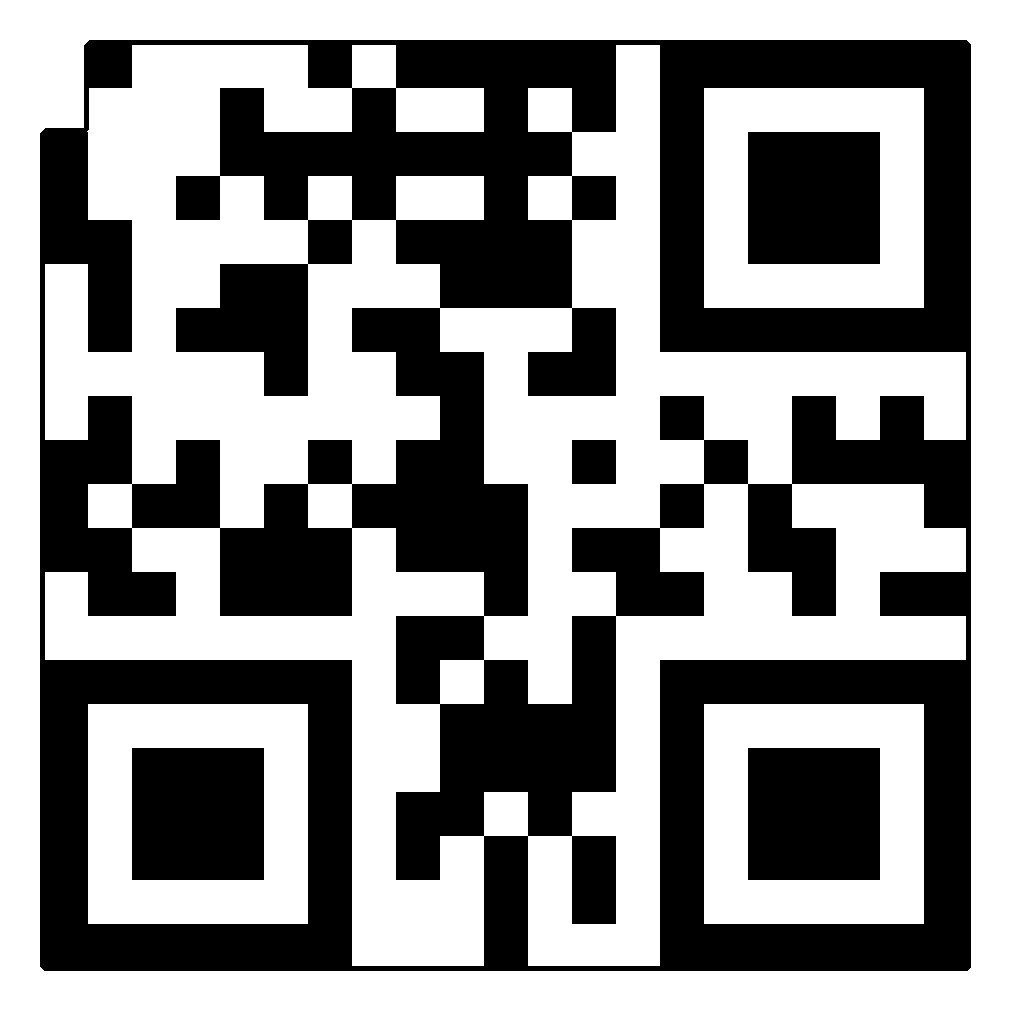

In [7]:
contourss = get_largest_square_contour(image_with_hough)

if contourss is not None:
    contour_img = image.copy()
    cv2.drawContours(contour_img, [contourss], -1, (0, 255, 0), 4)
else:
    print("No square contour found.")  # Pass the contour to drawContours

cv2_imshow(contour_img)

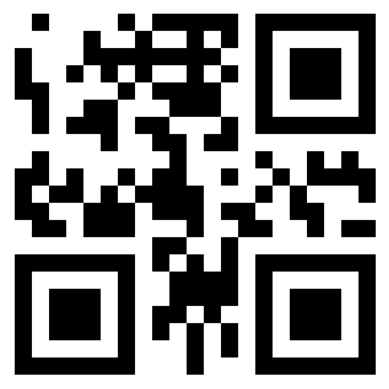

In [8]:
def zoom_in_on_contour(image, contour):
    # Get the bounding rectangle of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Define the ROI coordinates
    roi_x1 = max(x - 10, 0)  # Add some padding to the ROI
    roi_y1 = max(y - 10, 0)
    roi_x2 = min(x + w + 10, image.shape[1])
    roi_y2 = min(y + h + 10, image.shape[0])

    # Extract the ROI from the image
    roi = image[roi_y1:roi_y2, roi_x1:roi_x2]

    return roi

# Assuming you have the largest square contour stored in the variable largest_square_contour
if contourss is not None:
    # Zoom in on the contour
    zoomed_in_image = zoom_in_on_contour(image, contourss)

    # Display the zoomed-in image
    plt.imshow(zoomed_in_image, cmap='gray')
    plt.axis('off')
    plt.show()
else:
    print("No square contour found.")


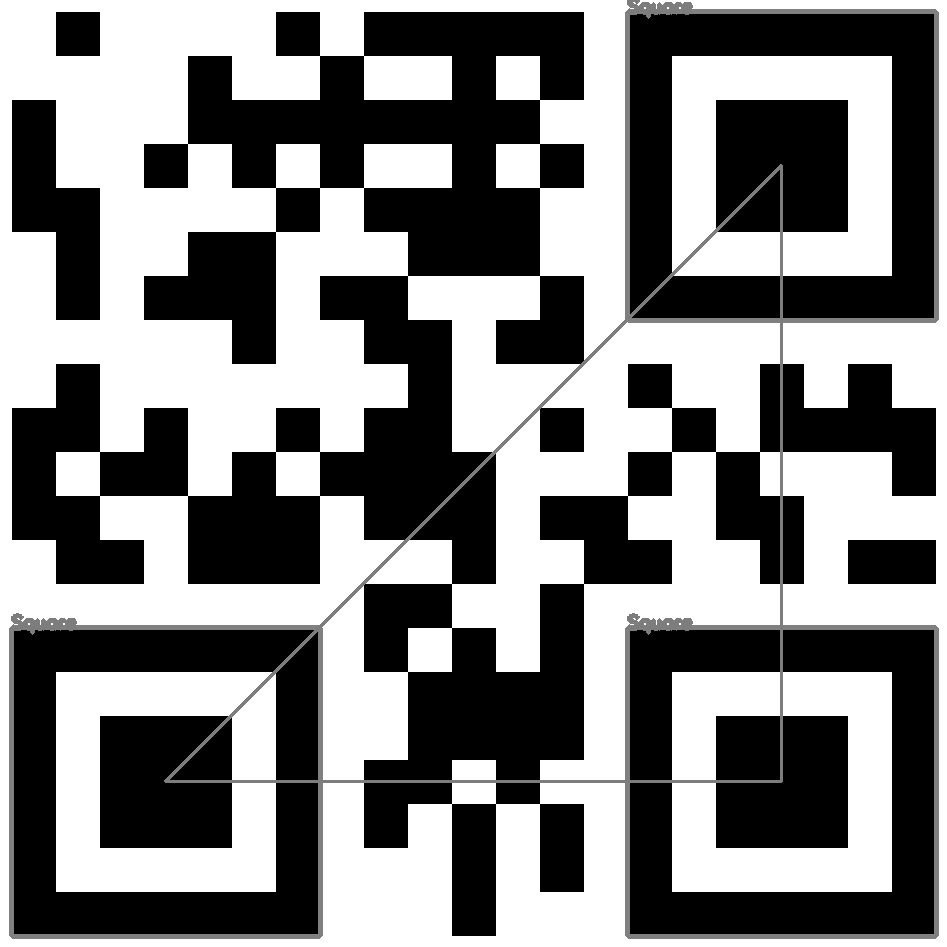

In [9]:
contours, _ = cv2.findContours(zoomed_in_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Initialize list to store squares and their dimensions
squares_with_dimensions = []

for cnt in contours:
    x1, y1 = cnt[0][0]
    approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)
    if len(approx) == 4:
        x, y, w, h = cv2.boundingRect(cnt)
        ratio = float(w) / h
        if ratio >= 0.9 and ratio <= 1.1:
            squares_with_dimensions.append((cnt, (x1, y1), w, h))

# Sort squares by area in descending order
squares_with_dimensions.sort(key=lambda x: cv2.contourArea(x[0]), reverse=True)

# Find the largest group of three squares with the same dimensions within a tolerance of ±5 pixels
largest_same_dim_squares = []
i = 0
while i < len(squares_with_dimensions) - 2:
    square_i = squares_with_dimensions[i]
    square_i1 = squares_with_dimensions[i + 1]
    square_i2 = squares_with_dimensions[i + 2]
    w_i, h_i = square_i[2:]
    w_i1, h_i1 = square_i1[2:]
    w_i2, h_i2 = square_i2[2:]
    if (abs(w_i - w_i1) <= 5 and abs(h_i - h_i1) <= 5) and (abs(w_i - w_i2) <= 5 and abs(h_i - h_i2) <= 5):
        largest_same_dim_squares.append((square_i, square_i1, square_i2))
        break
    i += 1

# Get centroids of squares
square_centers = [[np.mean(square[0], axis=0)[0] for square in squares] for squares in largest_same_dim_squares]

image_copy = zoomed_in_image.copy()

# Draw the contours and add text for square objects
for squares in largest_same_dim_squares:
    for square_info in squares:
        cnt, (x1, y1), _, _ = square_info
        cv2.drawContours(image_copy, [cnt], -1, (128, 128, 128), 3)
        cv2.putText(image_copy, "Square", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (125, 255, 0), 3)

# Draw lines between centroids of adjacent squares
if len(square_centers) == 1:
    centers = square_centers[0]
    if len(centers) == 3:
        for i in range(len(centers)):
            for j in range(i + 1, len(centers)):
                centroid_i = centers[i]
                centroid_j = centers[j]
                cv2.line(image_copy, (int(centroid_i[0]), int(centroid_i[1])), (int(centroid_j[0]), int(centroid_j[1])), (125, 255, 0), 2)

# Display the image
cv2_imshow(image_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

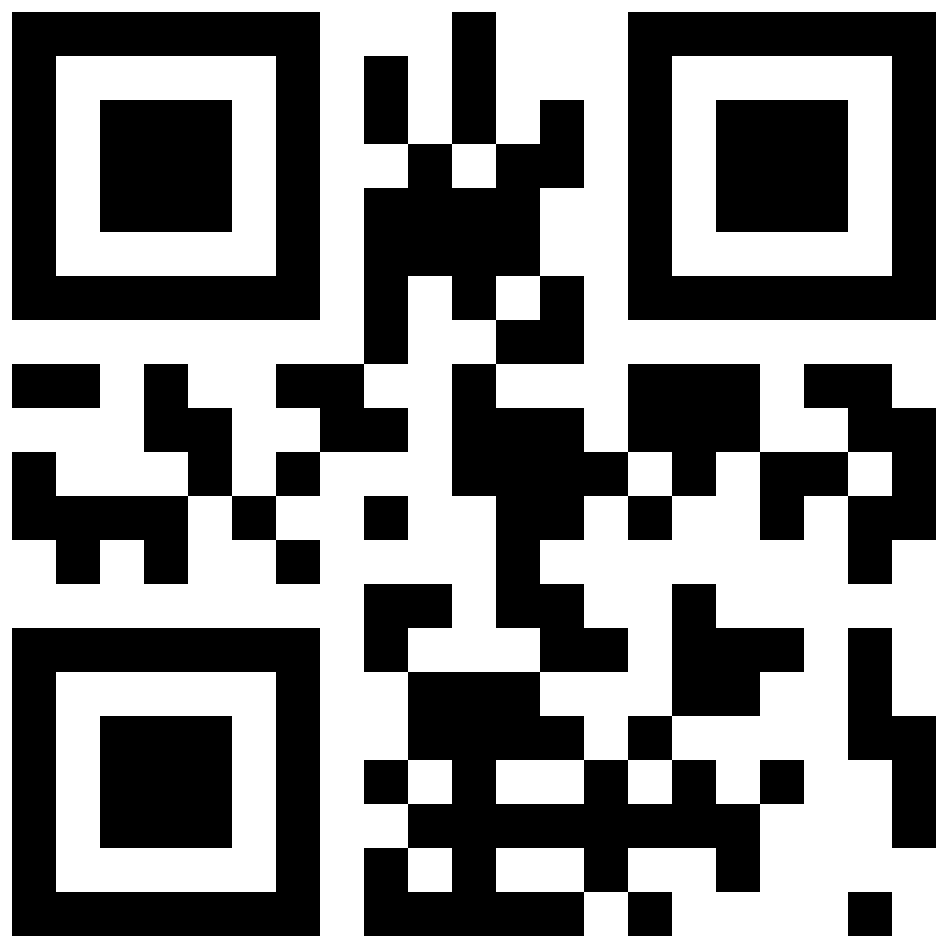

In [10]:
square_centers_flat = [center for squares in square_centers for center in squares]

center_x = (square_centers_flat[0][0] + square_centers_flat[1][0] + square_centers_flat[2][0]) / 3
center_y = (square_centers_flat[0][1] + square_centers_flat[1][1] + square_centers_flat[2][1]) / 3

# Determine which locator pattern is in the bottom-left corner
distances_to_center = [math.sqrt((center_x - x)**2 + (center_y - y)**2) for x, y in square_centers_flat]
bottom_left_idx = np.argmin(distances_to_center)

# Use the bottom-left locator pattern as the reference
ref_point = square_centers_flat[bottom_left_idx]

# Find the closest locator pattern to the right of the reference point
distances_to_ref = [math.sqrt((ref_point[0] - x)**2 + (ref_point[1] - y)**2) for x, y in square_centers_flat]
distances_to_ref[bottom_left_idx] = float('inf')  # Exclude the reference point itself
closest_right_idx = np.argmin(distances_to_ref)
closest_right_point = square_centers_flat[closest_right_idx]

# Calculate the angle to the right
x_diff = closest_right_point[0] - ref_point[0]
y_diff = closest_right_point[1] - ref_point[1]
orientation_angle = math.atan2(y_diff, x_diff) * (180 / math.pi)

# Adjust angle to standard range (0 to 360 degrees)
orientation_angle = (orientation_angle + 360) % 360

# Rotate the image to correct the tilt
rows, cols = zoomed_in_image.shape[:2]
rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), orientation_angle, 1)
rotated_image = cv2.warpAffine(zoomed_in_image, rotation_matrix, (cols, rows), borderMode=cv2.BORDER_REPLICATE)

# Display the image
cv2_imshow(rotated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:

# square_centers_flat = [center for squares in square_centers for center in squares]

# # Calculate the orientation of the QR code
# x_diff = square_centers_flat[1][0] - square_centers_flat[0][0]
# y_diff = square_centers_flat[1][1] - square_centers_flat[0][1]

# # Calculate the angle using atan2, ensuring the correct quadrant
# orientation_angle = math.atan2(y_diff, x_diff) * (180 / math.pi)

# # Adjust the angle for upside-down orientation
# if orientation_angle < 0:
#     orientation_angle += 180
# else:
#     orientation_angle -= 180

# # Rotate the image to correct the tilt
# rows, cols = zoomed_in_image.shape[:2]
# rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), orientation_angle, 1)
# rotated_image = cv2.warpAffine(zoomed_in_image, rotation_matrix, (cols, rows), borderMode=cv2.BORDER_REPLICATE)

# # Display the image
# cv2_imshow(rotated_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

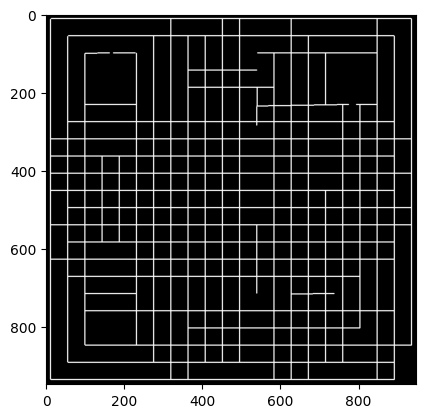

In [12]:
new_img = get_hough(rotated_image)
plt.imshow(new_img, cmap='gray')

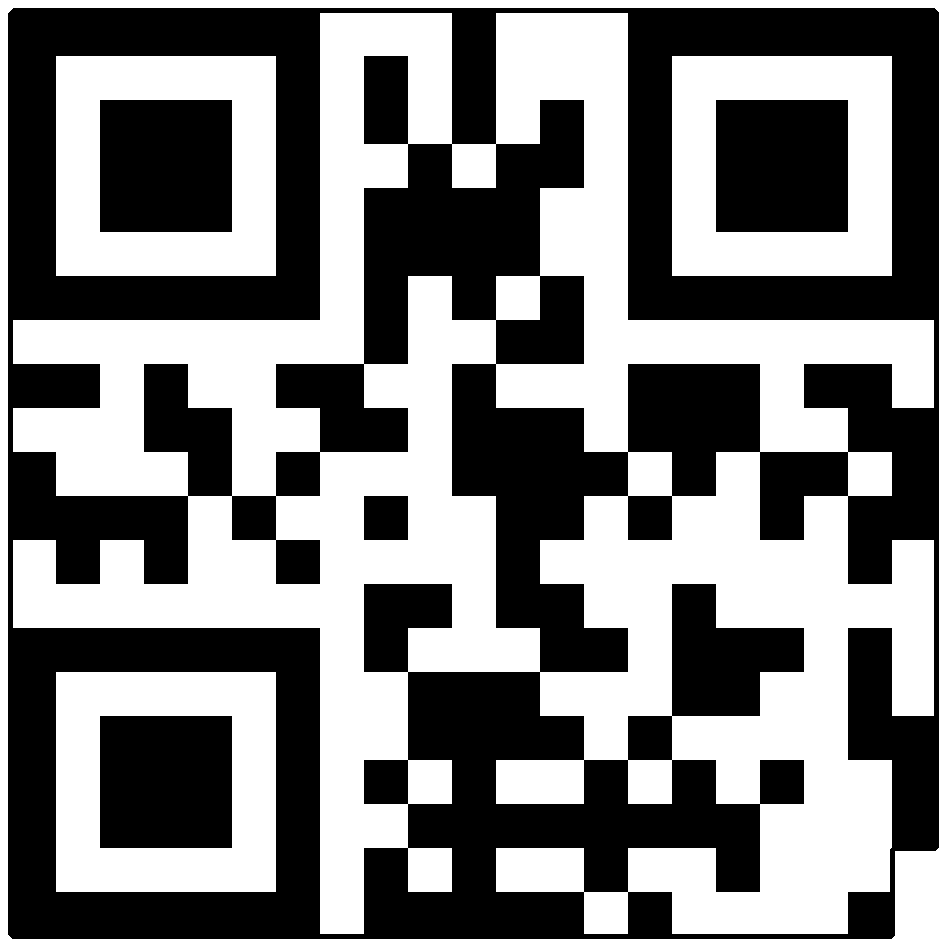

In [13]:
contourss = get_largest_square_contour(new_img)

if contourss is not None:
    contour_img = rotated_image.copy()
    cv2.drawContours(contour_img, [contourss], -1, (0, 255, 0), 4)
else:
    print("No square contour found.")  # Pass the contour to drawContours

cv2_imshow(contour_img)

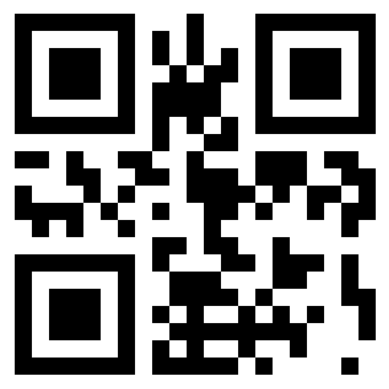

In [14]:
# Assuming you have the largest square contour stored in the variable largest_square_contour
if contourss is not None:
    # Zoom in on the contour
    zoomed_in_image = zoom_in_on_contour(rotated_image, contourss)

    # Display the zoomed-in image
    plt.imshow(zoomed_in_image, cmap='gray')
    plt.axis('off')
    plt.show()
else:
    print("No square contour found.")